In [1]:
%pip install pyradiomics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 13.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Discarding https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz (from https://pypi.org/simple/pyradiomics/): Requested pyradiomics from https://files.pythonhosted.org/packages/03/c1/20fc2c50ab1e3304da36d866042a1905a2b05a1431ece35448ab6b4578f2/pyradiomics-3.1.0.tar.gz has inconsistent version: expected '3.1.0', but metadata has '3.0.1a1'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 14.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117

In [2]:
# initial imports for the code
import logging
import matplotlib.pyplot as plt
import networkx as nx
import nibabel as nib
import numpy as np
import os
import pandas as pd
import SimpleITK as sitk
from radiomics import featureextractor
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Disabling pyradiomics warnings
logging.getLogger("radiomics").setLevel(logging.ERROR)

random_seed = 42 # This parameter was set as 42 in the whole experiment

### 1) Generating the radiomics features

In [7]:
# This function loads Nifti data and converts into Numpy array
def load_nii_as_numpy(file_path, verbose = True):

    # Loading the image
    nii_image = nib.load(file_path)
    image_data = nii_image.get_fdata()

    # You can avoid this additional printing by setting verbose as false
    if not verbose:
        return image_data

    # IMPORTANT
    # The affine matrix is inportant in case of rendering the array back as a Nifti
    # Because you must set it in the same translation as the original image
    affine = nii_image.affine  # The affine matrix is used for reverse transformation

    # Collecting metadata
    voxel_sizes = np.sqrt(np.sum(affine[:3, :3] ** 2, axis=0))

    center_voxel = np.array(image_data.shape) // 2
    center_physical = np.dot(affine, list(center_voxel) + [1])[:3]

    scanner_axes = ["RL" if affine[0, 0] < 0 else "LR",
                    "AP" if affine[1, 1] < 0 else "PA",
                    "IS" if affine[2, 2] < 0 else "SI"]

    image_info = {
        "Dimensão dos voxels": image_data.shape,
        "Voxels(mm)": voxel_sizes * image_data.shape,
        "Tamanho dos voxels(mm)": voxel_sizes,
        "Matriz afim": affine,
        "Centro": center_voxel,
        "Centro físico(mm)": center_physical,
        "Eixos": scanner_axes
    }

    # Showing the metadata
    print("Metadados do exame:")
    for key, value in image_info.items():
        print(f"{key}: {value}")

    return image_data


# Extracts the radiomic data by dividing the image in kernels and saves into a csv file
def extract_radiomics_features(nii_path, kernel_size, csv_name):

    # Reading the image file
    image_data = load_nii_as_numpy(nii_path)

    # By setting a different stride from the kernel, you may lost or repeat data!
    stride = kernel_size

    # Converting the image to simple ITK format
    itk_image = sitk.GetImageFromArray(image_data)

    # Starting the extractor and setting its fetures categories
    extractor = featureextractor.RadiomicsFeatureExtractor()
    extractor.enableFeaturesByName(
        firstorder=['Mean', 'Median', 'Variance'],
        gldm=['GrayLevelVariance']
    )

    # This feature list will be saved as a datarame
    features_list = []

    radius = kernel_size // 2
    count = 0

    print('\nIniciando extração radiômica')

    # Iteration through each axis
    for z in range(radius, image_data.shape[0] - radius, stride):
        for y in range(radius, image_data.shape[1] - radius, stride):
            for x in range(radius, image_data.shape[2] - radius, stride):
                # Defines the limits of the kernel in the image
                z_min, z_max = z - radius, z + radius + 1
                y_min, y_max = y - radius, y + radius + 1
                x_min, x_max = x - radius, x + radius + 1

                # Checking if the kernel has at least 70% of non zero values
                block = image_data[z_min:z_max, y_min:y_max, x_min:x_max]
                total_voxels = kernel_size ** 3
                non_zero_voxels = np.count_nonzero(block)

                if non_zero_voxels < total_voxels * 0.70:
                    continue # Skips kernels with more than 30% of air

                # Creating a mask for extracting radiomic features from the kernel
                mask = np.zeros_like(image_data, dtype=np.uint8)
                mask[z_min:z_max, y_min:y_max, x_min:x_max] = 1
                itk_mask = sitk.GetImageFromArray(mask) # Converting into simple ITK format

                try:
                    # Stores the radiomic data
                    features = extractor.execute(itk_image, itk_mask)
                    features_list.append({"x": x, "y": y, "z": z, **features})

                except Exception as e:
                    print(f"Erro ao processar a região {(x, y, z)}: {e}")
                    continue

                count += 1
                if count % 100 == 0:
                    print(count)

    df = pd.DataFrame(features_list)
    df.to_csv(csv_name, index=False)
    print(f"Tamanho do dataframe resultante: {df.shape}")
    print(f"Features salvas em: {csv_name}")

    return

kernel_size = 16
nii_path = "BraTS-MET-00104-000-t2f.nii.gz"
csv_name = nii_path.replace('nii.gz', 'csv')

extract_radiomics_features(nii_path, kernel_size, csv_name)

Metadados do exame:
Dimensão dos voxels: (240, 240, 155)
Voxels(mm): [240. 240. 155.]
Tamanho dos voxels(mm): [1. 1. 1.]
Matriz afim: [[  1.   0.  -0.  -0.]
 [  0.   1.  -0. 239.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]
Centro: [120 120  77]
Centro físico(mm): [120. 359.  77.]
Eixos: ['LR', 'PA', 'SI']

Iniciando extração radiômica
100
200
300
Tamanho do dataframe resultante: (371, 104)
Features salvas em: BraTS-MET-00104-000-t2f.csv


### 2) Checking the generated network and selecting clusters

Lendo BraTS-MET-00104-000-t2f.csv
Número de features: 31
Número de vértices no grafo: 50
Número de arestas no grafo: 273


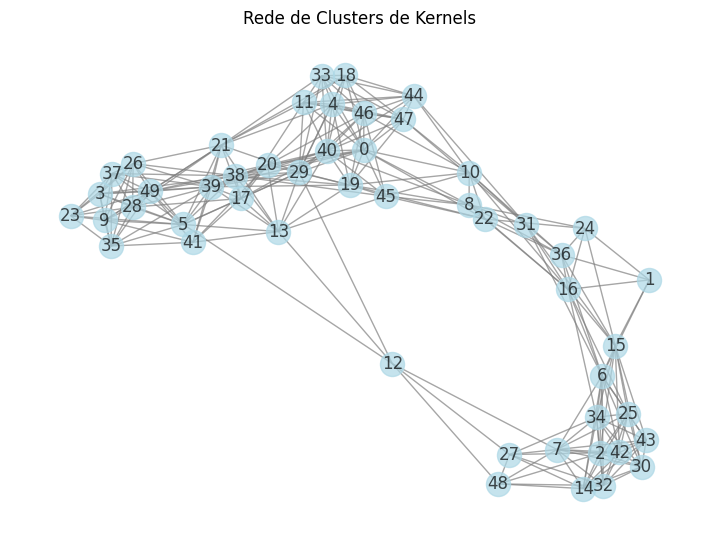

In [11]:
def generate_network(filename, n_clusters, minimal_correlation, link_threshold, kernel_size):

    # Reading the radiomics features csv
    print(f'Lendo {filename}')
    df = pd.read_csv(filename)

    # For feature selection purposes, the features list starts in the column 40
    features = df.drop(columns=['x', 'y', 'z']).iloc[:, 40:].values

    # Normalizing features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(features)

    # Removing features with internal correlation greater than the set value
    corr_matrix = np.corrcoef(normalized_features.T)
    upper_triangle = np.triu(corr_matrix, k=1)  # Apenas a parte superior da matriz de correlação
    redundant_features = np.where(np.abs(upper_triangle) > minimal_correlation)  # Encontrar correlações > 0.9
    redundant_features = sorted(set(redundant_features[0]))

    # This will be the used features list
    features_filtered = np.delete(normalized_features, redundant_features, axis=1)

    print('Número de features:', features_filtered.shape[1])

    # Using Kmeans clustering technique
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_seed)
    cluster_labels = kmeans.fit_predict(features_filtered)

    # The resultant clusters are stored in a dataframe in order to retrieve the kernels that belongs to it
    df['cluster'] = cluster_labels
    df[['x', 'y', 'z', 'cluster']].to_csv("cluster_mapping.csv", index=False)
    # print("Mapeamento de clusters salvo como cluster_mapping.csv")

    # >>> The complex network starts here

    # Since there can be many elements per cluster, we apply a mean
    cluster_features = []
    for cluster in range(n_clusters):
        cluster_data = features_filtered[cluster_labels == cluster]
        cluster_features.append(cluster_data.mean(axis=0))
    cluster_features = np.array(cluster_features)

    # Calculating the clusters similarities by the inverse of vectors distance
    similarity_matrix = squareform(1 - pdist(cluster_features, metric='correlation'))

    # Only sets links where the similarity matrix values are greater than the threshold
    adjacency_matrix = (similarity_matrix >= link_threshold).astype(int)

    # Creating the network with the clusters and selected links
    G = nx.Graph()

    for i in range(n_clusters):
        G.add_node(i, cluster_center=kmeans.cluster_centers_[i]) # Adding the nodes

    # Adding the selected links, they must store the similarity weight
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            if adjacency_matrix[i, j]:
                G.add_edge(i, j, weight=similarity_matrix[i, j])

    print("Número de vértices no grafo:", n_clusters)
    print("Número de arestas no grafo:", G.number_of_edges())

    # Storing the positions for graph ploting
    pos = nx.spring_layout(G, weight='weight', seed=random_seed)  # Fixar a seed

    # 9. Visualizar o grafo
    plt.figure(figsize=(7, 5))
    nx.draw(
        G, pos,
        with_labels=True,
        node_size=300,
        node_color="lightblue",
        edge_color="gray",
        alpha=0.7
    )
    plt.title("Rede de Clusters de Kernels")
    plt.show()

    return G

filename = "BraTS-MET-00104-000-t2f.csv"
n_clusters = 50  # Number of clusters
minimal_correlation = 0.9 # Minimal value for correlations
link_threshold = 0.4 # Minimal value for link formation
kernel_size = 16 # Must be the same size of the kernel in the previous cell
G = generate_network(filename, n_clusters, minimal_correlation, link_threshold, kernel_size)

In [14]:
# Selects the most distant and less conected nodes
def select_distant_low_degree_nodes(graph, num_nodes=3):

    # Calculates the centrality degree(number of connections of each node)
    degree_centrality = nx.degree_centrality(graph)

    # Calculates the closeness centrality, then applies 1 - closeness centrality
    closeness_centrality = nx.closeness_centrality(graph)
    inverted_closeness = {node: 1 - value for node, value in closeness_centrality.items()}

    # Both metrics have the same weight
    combined_score = {
        node: degree_centrality[node] + inverted_closeness[node]
        for node in graph.nodes
    }

    # Returns the first N elements, which represents the less connected
    selected_clusters = sorted(combined_score, key=combined_score.get)[:num_nodes]

    print("Clusters selecionados:", selected_clusters)
    return selected_clusters

num_nodes = 3
selected_clusters = select_distant_low_degree_nodes(G, num_nodes)

# Instead of using a algorithm clusters selection, you can test a statical list
# selected_clusters = [12, 22, 48, 5, 28]

Clusters selecionados: [12, 22, 48]


### 3) Converting the selected clusters into segmentation

In [15]:
def generate_segmentation(mask_filename, kernel_size, selected_clusters):

    # Reading the previous cluster mapping
    df = pd.read_csv("cluster_mapping.csv")

    # Filters only the selected clusters, and retrieves its original kernels
    selected_kernels = df[df['cluster'].isin(selected_clusters)]

    # Creates an empty 3D image
    # IMPORTANT: if your image have different dimensions, you MUST change this section
    image_shape = (240, 240, 155)
    mask = np.zeros(image_shape, dtype=np.uint8)

    # This radius will be used with the kernel center to implement segmentation
    kernel_radius = kernel_size // 2

    for _, row in selected_kernels.iterrows():
        x, y, z = int(row['z']), int(row['y']), int(row['x'])  # Centro do kernel

        # Fills each kernel region in the limits of the coordinates
        x_min, x_max = max(0, x - kernel_radius), min(image_shape[0], x + kernel_radius)
        y_min, y_max = max(0, y - kernel_radius), min(image_shape[1], y + kernel_radius)
        z_min, z_max = max(0, z - kernel_radius), min(image_shape[2], z + kernel_radius)
        mask[x_min:x_max, y_min:y_max, z_min:z_max] = 1 # All these voxels are set as segmented


    affine = np.eye(4)
    # IMPORTANT: the section below is important to keep the same center of the used dataset
    # For different images, you may remove or change the parameter
    affine[1, 3] = 239 # Defines the y axis origin in 239mm

    # Storing the final mask
    mask_nifti = nib.Nifti1Image(mask, affine=affine)
    nib.save(mask_nifti, mask_filename)

    print(f"Máscara salva como {mask_filename}")

mask_filename = 'segmented_mask.nii.gz'
# You MUST keep the kernel_size parameter
generate_segmentation(mask_filename, kernel_size, selected_clusters)


Máscara salva como segmented_mask.nii.gz


### 4) Calculating similarity by using the IoU score

In [19]:
def iou_score(file1, file2):

    # Loads both files(the order doesn't matter)
    img1 = nib.load(file1).get_fdata()
    img2 = nib.load(file2).get_fdata()

    # Both images must have the same dimension
    if img1.shape != img2.shape:
        raise ValueError("As dimensões dos arquivos não coincidem.")

    # Converting into a binary mask, just to make sure
    img1 = (img1 > 0).astype(np.int32)
    img2 = (img2 > 0).astype(np.int32)

    # Calculating intersection and union
    intersection = np.sum((img1 & img2) > 0)
    union = np.sum((img1 | img2) > 0)

    # Avoind zero division
    if union == 0:
        print('ERRO')
        return

    # Returns the IoU
    iou = intersection / union
    print(f"O IoU entre as máscaras é de {iou:.4f}")
    return

file1 = "segmented_mask.nii.gz"
file2 = "BraTS-MET-00104-000-seg.nii.gz"
iou_score(file1, file2)

O IoU entre as máscaras é de 0.1910


As can be seen, the score of 0.19(19% of correspondence) was the best score obtained in the tests. The result is far below the state of the art in segmentation.